In [97]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
import pickle
import joblib

In [98]:
# Load the train dataset from CSV
train_df = pd.read_csv(r'D:\Face Recognetion\train.csv')

# Load the test dataset from CSV
test_df = pd.read_csv(r'D:\Face Recognetion\test.csv')

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

# Concatenate the datasets into a single DataFrame
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Display the merged dataset
print("Combined Data:\n", combined_df.head())

Combined Data:
    emotion                                             pixels dataset
0      0.0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...   train
1      0.0  151 150 147 155 148 133 111 140 170 174 182 15...   train
2      2.0  231 212 156 164 174 138 161 173 182 200 106 38...   train
3      4.0  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...   train
4      6.0  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...   train


In [99]:
# Checking Shape of data
combined_df.shape

(35887, 3)

In [100]:
combined_df.duplicated

<bound method DataFrame.duplicated of        emotion                                             pixels dataset
0          0.0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...   train
1          0.0  151 150 147 155 148 133 111 140 170 174 182 15...   train
2          2.0  231 212 156 164 174 138 161 173 182 200 106 38...   train
3          4.0  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...   train
4          6.0  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...   train
...        ...                                                ...     ...
35882      NaN  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...    test
35883      NaN  178 174 172 173 181 188 191 194 196 199 200 20...    test
35884      NaN  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...    test
35885      NaN  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...    test
35886      NaN  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...    test

[35887 rows x 3 columns]>

## Data Visualization>>>

In [101]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

In [102]:
combined_df['emotion'].value_counts()

3.0    7215
6.0    4965
4.0    4830
2.0    4097
0.0    3995
5.0    3171
1.0     436
Name: emotion, dtype: int64

In [103]:
print(f"Number of rows for label_to_text {label_to_text}: {len(combined_df[combined_df.emotion == label_to_text])}")

Number of rows for label_to_text {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}: 0


In [104]:
print(combined_df[combined_df.emotion == label_to_text].pixels.isna().sum())

0


In [105]:
print(combined_df.head())

   emotion                                             pixels dataset
0      0.0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...   train
1      0.0  151 150 147 155 148 133 111 140 170 174 182 15...   train
2      2.0  231 212 156 164 174 138 161 173 182 200 106 38...   train
3      4.0  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...   train
4      6.0  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...   train


In [106]:
for label in sorted(combined_df.emotion.unique()):
    count = combined_df[combined_df.emotion == label].shape[0]
    print(f"Label {label} has {count} rows.")


Label 0.0 has 3995 rows.
Label 1.0 has 436 rows.
Label 2.0 has 4097 rows.
Label 3.0 has 7215 rows.
Label 4.0 has 4830 rows.
Label 5.0 has 3171 rows.
Label 6.0 has 4965 rows.
Label nan has 0 rows.


In [107]:
# Remove rows with any null values
combined_df = combined_df.dropna()

# Remove rows where all elements are null
combined_df = combined_df.dropna(how='all')

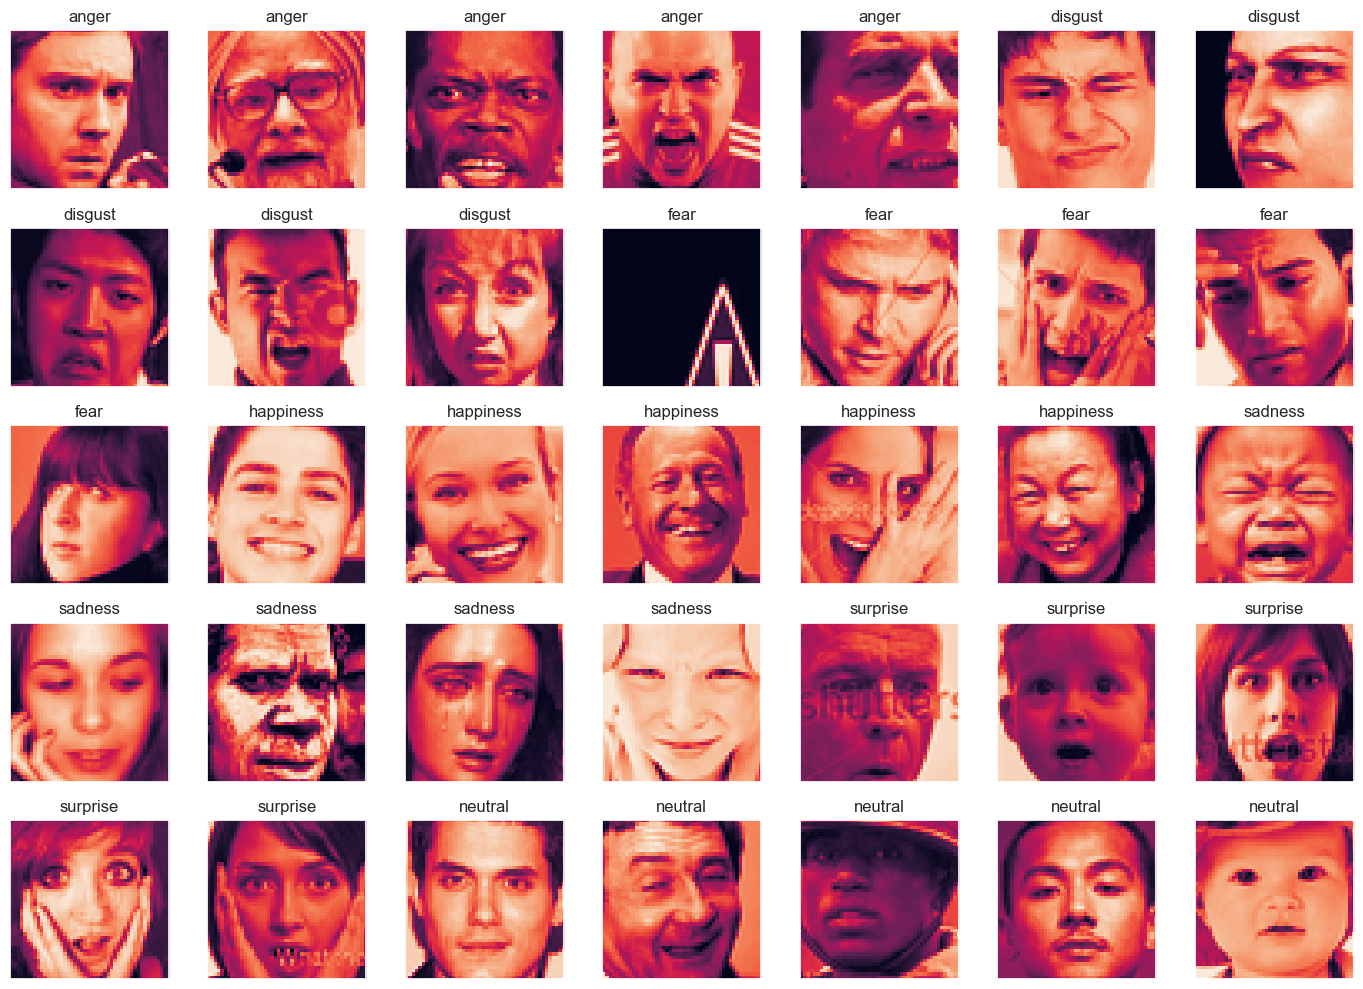

In [108]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(combined_df.emotion.unique()):
    for j in range(5):
        px = combined_df[combined_df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [109]:
# Checking Emotion Class Distribution
combined_df['emotion'].value_counts()


3.0    7215
6.0    4965
4.0    4830
2.0    4097
0.0    3995
5.0    3171
1.0     436
Name: emotion, dtype: int64

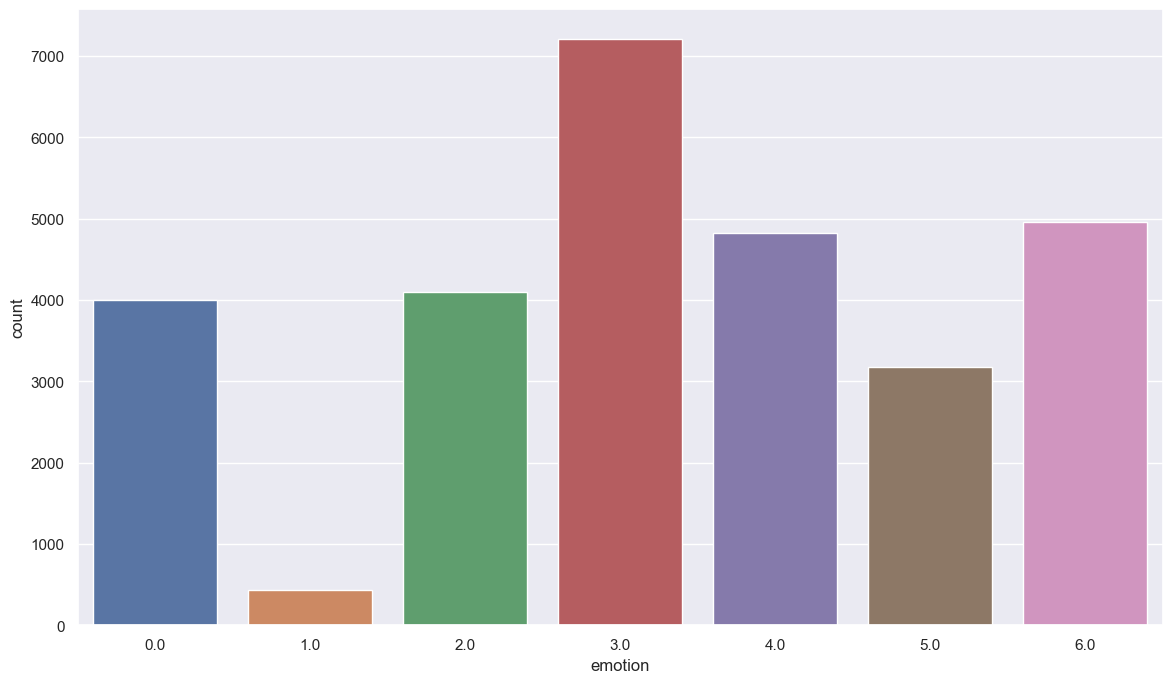

In [110]:
# Plotting the above distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=combined_df)

## Data Pre-Processing 

In [111]:
# Split the data into feature & target variable
x_data = combined_df['pixels']
y_data = combined_df['emotion']

In [112]:
# Check for NaNs in x_data and y_data
print(x_data.isna().sum())
print(y_data.isna().sum())

# Drop NaNs if necessary
x_data = x_data.dropna()
y_data = y_data.dropna()

# Alternatively, you can fill NaNs with a specific value
x_data = x_data.fillna(0)

0
0


In [123]:
# Assuming y_data should match the length of x_data
# Remove extra data from y_data if needed

# Ensure y_data matches x_data
if len(y_data) > len(x_data):
    y_data = y_data[:len(x_data)]
elif len(x_data) > len(y_data):
    x_data = x_data[:len(y_data)]

# Verify the new shapes
print(f"Adjusted x_data shape: {x_data.shape}")
print(f"Adjusted y_data shape: {y_data.shape}")

Adjusted x_data shape: (50505, 1)
Adjusted y_data shape: (50505,)


In [122]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(50505, 1)   (50505,)


In [121]:
# Let's check the distributio of target data again after balancing
y_data.value_counts()

3.0    7215
6.0    7215
5.0    7215
1.0    7215
4.0    7215
2.0    7215
0.0    7215
Name: emotion, dtype: int64

In [119]:
# Assuming y_data should match the length of x_data
# Remove extra data from y_data if needed

# Ensure y_data matches x_data
if len(y_data) > len(x_data):
    y_data = y_data[:len(x_data)]
elif len(x_data) > len(y_data):
    x_data = x_data[:len(y_data)]

# Verify the new shapes
print(f"Adjusted x_data shape: {x_data.shape}")
print(f"Adjusted y_data shape: {y_data.shape}")

Adjusted x_data shape: (50505,)
Adjusted y_data shape: (50505,)


In [124]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
50500    64 43 0 13 45 36 32 38 37 32 31 37 39 41 40 43...
50501    0 0 0 0 0 0 1 1 1 0 1 4 17 52 101 124 132 135 ...
50502    145 145 146 147 148 148 149 150 149 155 129 83...
50503    22 42 82 124 160 192 223 225 228 237 247 253 2...
50504    89 94 88 94 95 93 93 89 85 95 88 94 101 99 104...
Length: 50505, dtype: object

In [125]:
# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [126]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(50505, 48, 48, 1)

In [67]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(50505, 1)

In [68]:
print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")


x_data shape: (50505, 48, 48, 1)
y_data shape: (50505, 1)


In [69]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [70]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((45454, 48, 48, 1), (5051, 48, 48, 1), (45454, 1), (5051, 1))

In [71]:
# Perform One-Hot Encoding on training data
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(45454, 7)

In [72]:
# Perform One-Hot Encoding on test data
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(5051, 7)

## Model Building

In [73]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(250, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                        

## Model Training

In [145]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [146]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam , loss='categorical_crossentropy', metrics=['accuracy'])

## Dont run it just import it from Model_save

In [34]:
history = model.fit(x_train, y_train, epochs = 35, validation_data=(x_test, y_test))

Epoch 1/35
1421/1421 [==============================] - 1458s 1s/step - loss: 1.8491 - accuracy: 0.2608 - val_loss: 1.7477 - val_accuracy: 0.3459
Epoch 2/35
1421/1421 [==============================] - 1191s 838ms/step - loss: 1.5879 - accuracy: 0.3870 - val_loss: 1.4437 - val_accuracy: 0.4558
Epoch 3/35
1421/1421 [==============================] - 1189s 836ms/step - loss: 1.4222 - accuracy: 0.4591 - val_loss: 1.2916 - val_accuracy: 0.5185
Epoch 4/35
1421/1421 [==============================] - 1180s 830ms/step - loss: 1.3077 - accuracy: 0.5014 - val_loss: 1.2043 - val_accuracy: 0.5482
Epoch 5/35
1421/1421 [==============================] - 1167s 821ms/step - loss: 1.2161 - accuracy: 0.5371 - val_loss: 1.1210 - val_accuracy: 0.5757
Epoch 6/35
1421/1421 [==============================] - 1177s 828ms/step - loss: 1.1459 - accuracy: 0.5641 - val_loss: 1.0527 - val_accuracy: 0.5985
Epoch 7/35
1421/1421 [==============================] - 1161s 817ms/step - loss: 1.0881 - accuracy: 0.5871 - 

In [143]:
with open('history.pkl', 'wb') as d:
    pickle.dump(history, d)
    d.close()

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
    f.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_2
......vars
...layers\activation_3
......vars
...layers\activation_4
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......va

## Model Evaluation 

In [144]:
model = joblib.load('model.pkl')
model = joblib.load('history.pkl')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-11-30 19:44:48         3135
metadata.json                                  2024-11-30 19:44:48           64
variables.h5                                   2024-11-30 19:44:48     13039296


ValueError: Unknown metric function: 'function'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [78]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(45454, 48, 48, 1)
(45454, 7)
(5051, 48, 48, 1)
(5051, 7)


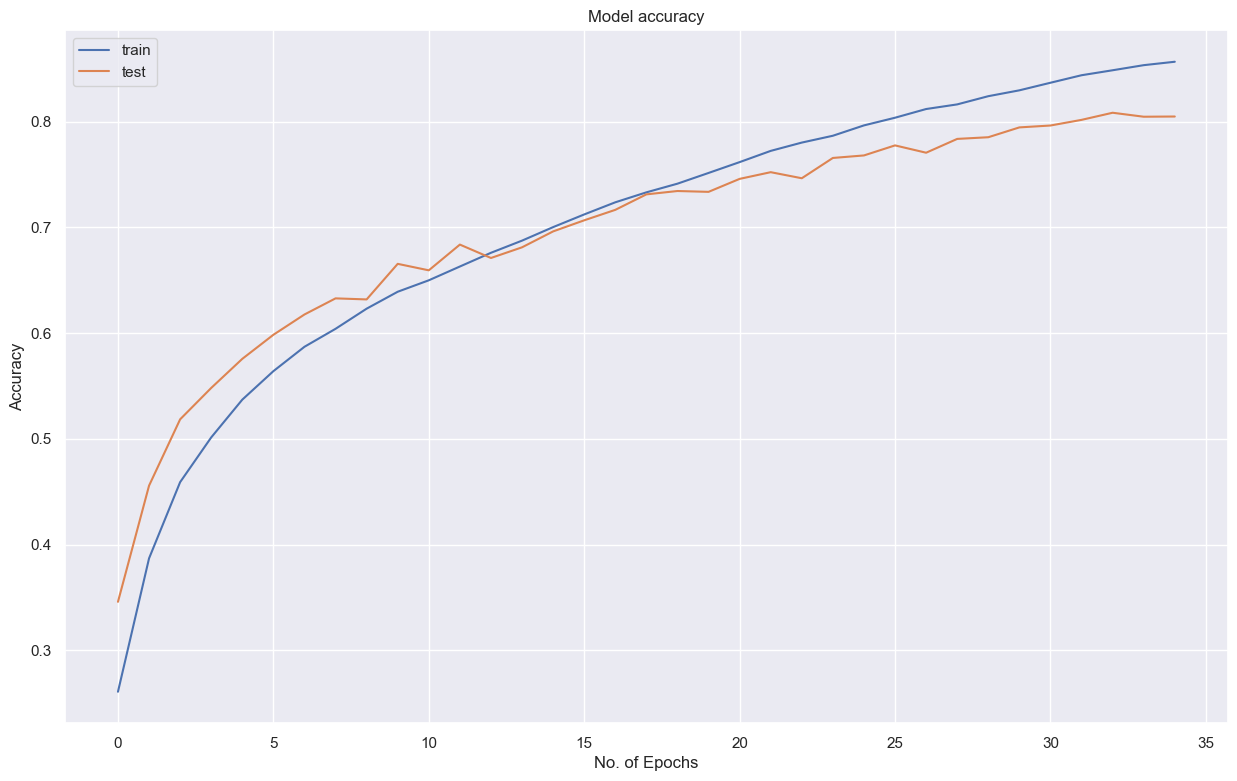

In [133]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

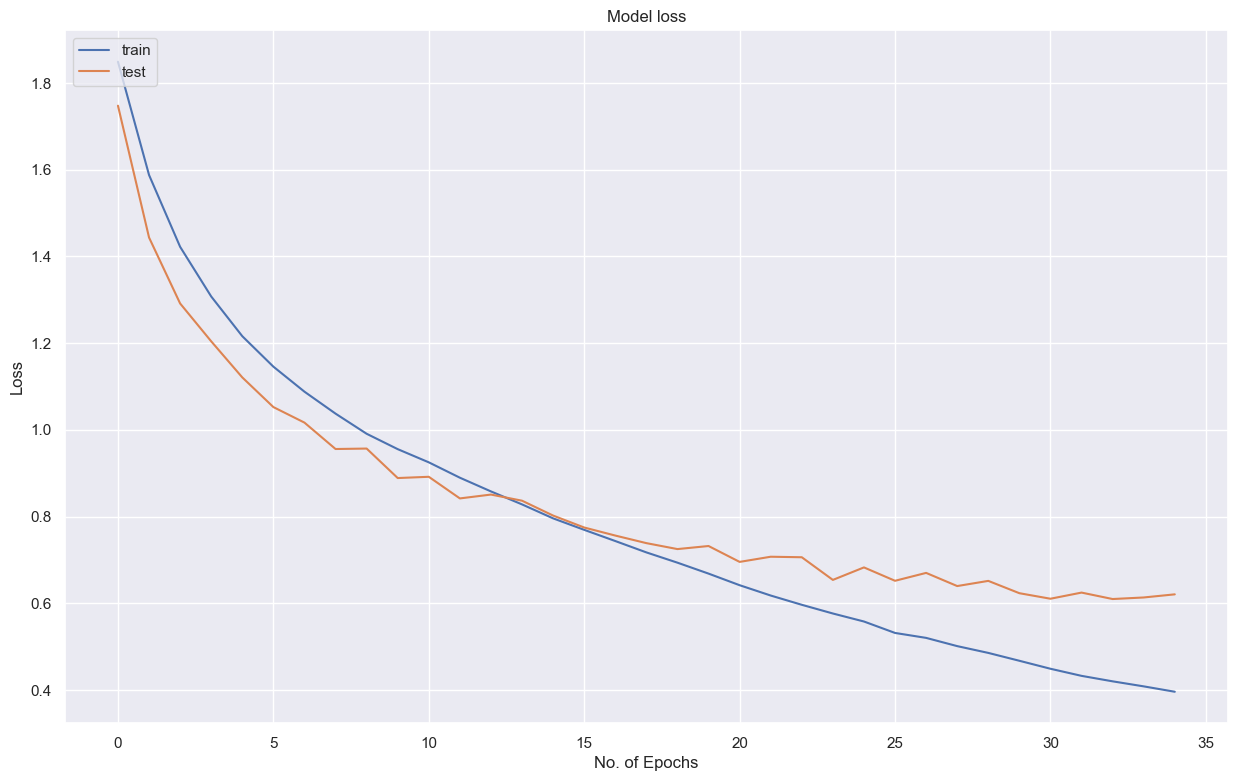

In [39]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## classification report

In [134]:
# Making Predictio on Test Data
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

158/158 [==============================] - 36s 223ms/step


[3, 3, 1, 3, 3, 3, 3, 3, 3, 3]

In [135]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[0, 0, 0, 2, 5, 2, 2, 2, 2, 6]

In [136]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       692
           1       0.12      0.07      0.09       698
           2       0.00      0.00      0.00       735
           3       0.15      0.93      0.26       756
           4       0.00      0.00      0.00       711
           5       0.00      0.00      0.00       753
           6       0.00      0.00      0.00       706
           9       0.00      0.00      0.00         0

    accuracy                           0.15      5051
   macro avg       0.16      0.12      0.04      5051
weighted avg       0.18      0.15      0.05      5051



c:\Users\nohaa\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nohaa\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nohaa\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Text(179.75, 0.5, 'Truth')

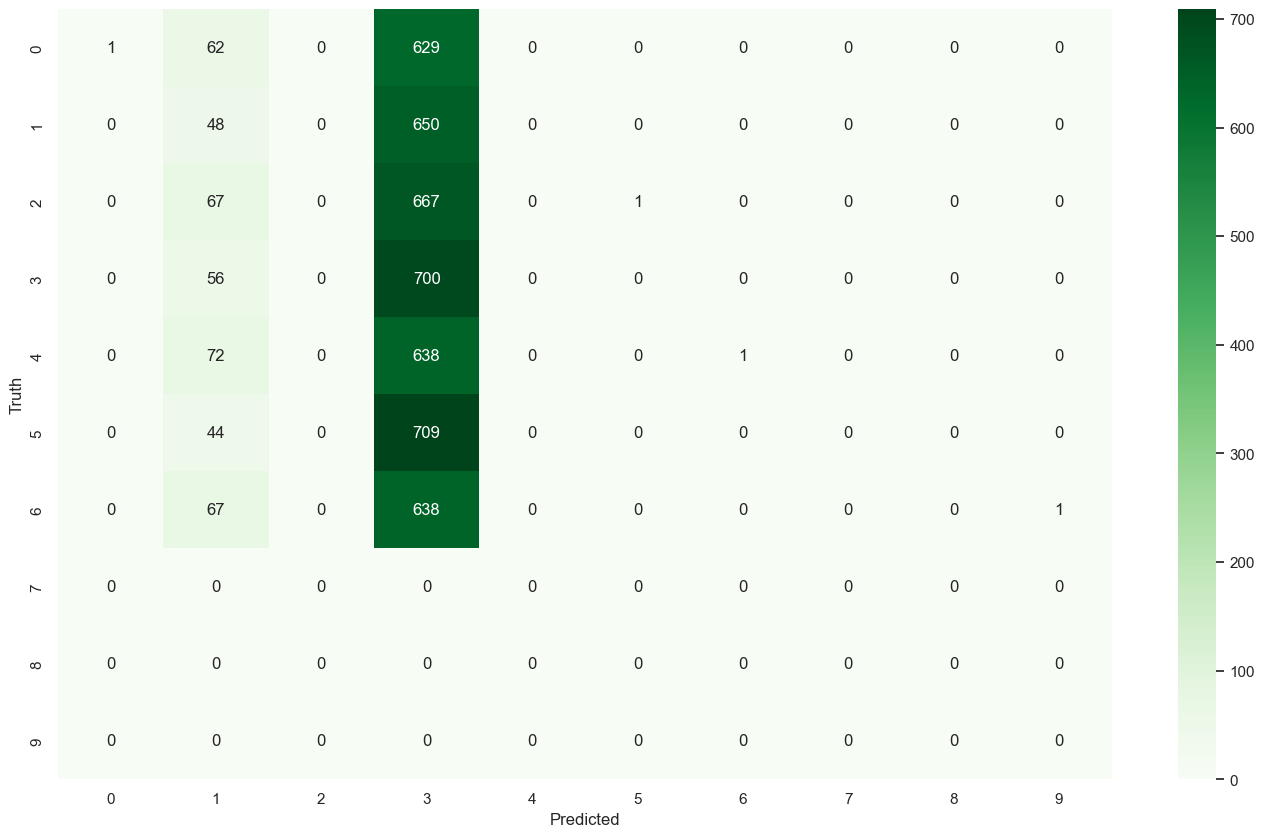

In [137]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [138]:
# Evaluate model performance on test data
y_pred = model.predict(x_test)
y_result = [np.argmax(pred) for pred in y_pred]

# Compare with the actual values
y_actual = [np.argmax(pred) for pred in y_test]

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_result))

158/158 [==============================] - 26s 166ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       692
           1       0.12      0.07      0.09       698
           2       0.00      0.00      0.00       735
           3       0.15      0.93      0.26       756
           4       0.00      0.00      0.00       711
           5       0.00      0.00      0.00       753
           6       0.00      0.00      0.00       706
           9       0.00      0.00      0.00         0

    accuracy                           0.15      5051
   macro avg       0.16      0.12      0.04      5051
weighted avg       0.18      0.15      0.05      5051



c:\Users\nohaa\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nohaa\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nohaa\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [139]:
# Save the trained model
model.save('emotion_recognition_final_model.h5')


In [140]:
from keras.models import load_model

# Load the saved model
model = load_model('emotion_recognition_final_model.h5')


## **9. Making Prediction in a Real-Time**

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

# Load your trained model
model = tf.keras.models.load_model('emotion_recognition_final_model.h5')

# Emotion labels
emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Initialize webcam
cap = cv2.VideoCapture(0)

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    # Loop over detected faces
    for (x, y, w, h) in faces:
        # Extract the region of interest (face)
        face = frame[y:y+h, x:x+w]
        
        # Preprocess the face image: resize, convert to grayscale, normalize, and reshape for the model
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face_gray = cv2.resize(face_gray, (48, 48))
        face_gray = face_gray.astype('float32') / 255
        face_gray = img_to_array(face_gray)
        face_gray = np.expand_dims(face_gray, axis=0)
        face_gray = np.expand_dims(face_gray, axis=-1)
        
        # Predict emotion
        emotion_prob = model.predict(face_gray)
        emotion_label = np.argmax(emotion_prob)

        # Display the emotion label on the frame
        cv2.putText(frame, emotion_dict[emotion_label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Emotion Detection', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 84ms/step
